# Explore GRS images

## Load python libraries

In [1]:

import glob
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray  # activate the rio accessor
from shapely.geometry import box
import datetime as dt

import hvplot.xarray
import pyproj as ppj

#import cartopy
import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import locale
#locale.setlocale(locale.LC_ALL, 'en_US.utf8')
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.use('TkAgg')


plt.rcParams.update({'font.family': 'Times New Roman',
                     'font.size': 16, 'axes.labelsize': 18,

                     })

rc = {"font.family" : "serif",
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

import panel as pn

import grs
import grstbx
from grstbx import visual


u = grstbx.utils
opj = os.path.join


print(f'-grs: {grs.__version__}')
print(f'-grstbx: {grstbx.__version__}')

-grs: 2.2.0
-grstbx: 2.0.2


## HYPERNETS data base

In [2]:
idir='/DATA/hypernets/'
site = 'BEFR' #''BEFR'
files=glob.glob(opj(idir,site,'*','*','*','*','*.nc'))
xr.open_dataset(files[0])

<xarray.Dataset> Size: 65kB
Dimensions:                     (wavelength: 1019, series: 1)
Coordinates:
  * wavelength                  (wavelength) float64 8kB 399.8 400.3 ... 899.4
Dimensions without coordinates: series
Data variables: (12/17)
    bandwidth                   (wavelength) float64 8kB ...
    viewing_azimuth_angle       (series) float64 8B ...
    viewing_zenith_angle        (series) float64 8B ...
    solar_azimuth_angle         (series) float64 8B ...
    solar_zenith_angle          (series) float64 8B ...
    acquisition_time            (series) float64 8B ...
    ...                          ...
    epsilon                     (series) float64 8B ...
    rhof                        (series) float64 8B ...
    fresnel_wind                (series) float64 8B ...
    reflectance_std             (wavelength, series) float64 8kB ...
    water_leaving_radiance_std  (wavelength, series) float64 8kB ...
    reflectance_nosc_std        (wavelength, series) float64 8kB ...
Attributes: (12/55)
    type:                             dataset
    abstract:                         The HYPERNETS project (Horizon 2020 res...
    conventions:                      CFv72, NVS2.0
    format_version:                   v01.0
    netcdf_version:                   1.6
    processor_name:                   hypernets_processor
    ...                               ...
    lineage:                          Quality assured following automated thr...
    creator_name:                     Clémence Goyens (RBINS, OD Nature, REMSEM)
    creator_email:                    https://waterhypernet.org/contact/
    history:                          Reflectance is computed by measuring th...
    site_manager:                     David Doxaran (SU, LOV, France)
    site_manager_email:               david.doxaran@imev-mer.fr

Generate unified NetCDF file with the whole HYPERNETS timeseries (if does not exist)

In [3]:
file = opj('/DATA/hypernets',site,site+'_hypernets.nc')
if not os.path.exists(file):
    Nfile =len(files)
    inc=50
    hypernets = []
    for ii in range(0,Nfile+1,inc):
        print(ii)
        ds = xr.open_mfdataset(files[ii:ii+inc-1],combine="nested",concat_dim='time').squeeze().load()
        ds['time']=pd.to_datetime(ds.acquisition_time.values, unit='s')
        hypernets.append(ds)
    hypernets=xr.concat(hypernets,dim='time')
    hypernets = hypernets.sortby('time')
    hypernets['Rrs']=hypernets.reflectance_nosc/np.pi
    hypernets=hypernets.rename_dims({'wavelength':'wl'}).rename_vars({'wavelength':'wl'})

    hypernets.to_netcdf(file)

hypernets=xr.open_dataset(file)

insitu_param='Rrs'
if site == 'BEFR':
    hypernets['Rrs_corr']=hypernets.reflectance/np.pi
    insitu_param='Rrs_corr'
hypernets

<xarray.Dataset> Size: 138MB
Dimensions:                     (time: 1876, wl: 1019)
Coordinates:
  * wl                          (wl) float64 8kB 399.8 400.3 ... 898.9 899.4
  * time                        (time) datetime64[ns] 15kB 2021-02-24T11:33:4...
Data variables: (12/19)
    bandwidth                   (time, wl) float64 15MB ...
    viewing_azimuth_angle       (time) float64 15kB ...
    viewing_zenith_angle        (time) float64 15kB ...
    solar_azimuth_angle         (time) float64 15kB ...
    solar_zenith_angle          (time) float64 15kB ...
    acquisition_time            (time) float64 15kB ...
    ...                          ...
    fresnel_wind                (time) float64 15kB ...
    reflectance_std             (time, wl) float64 15MB ...
    water_leaving_radiance_std  (time, wl) float64 15MB ...
    reflectance_nosc_std        (time, wl) float64 15MB ...
    Rrs                         (time, wl) float64 15MB ...
    Rrs_corr                    (time, wl) float64 15MB 0.003861 ... 8.443e-05
Attributes: (12/55)
    type:                             dataset
    abstract:                         The HYPERNETS project (Horizon 2020 res...
    conventions:                      CFv72, NVS2.0
    format_version:                   v01.0
    netcdf_version:                   1.6
    processor_name:                   hypernets_processor
    ...                               ...
    lineage:                          Quality assured following automated thr...
    creator_name:                     Clémence Goyens (RBINS, OD Nature, REMSEM)
    creator_email:                    https://waterhypernet.org/contact/
    history:                          Reflectance is computed by measuring th...
    site_manager:                     David Doxaran (SU, LOV, France)
    site_manager_email:               david.doxaran@imev-mer.fr

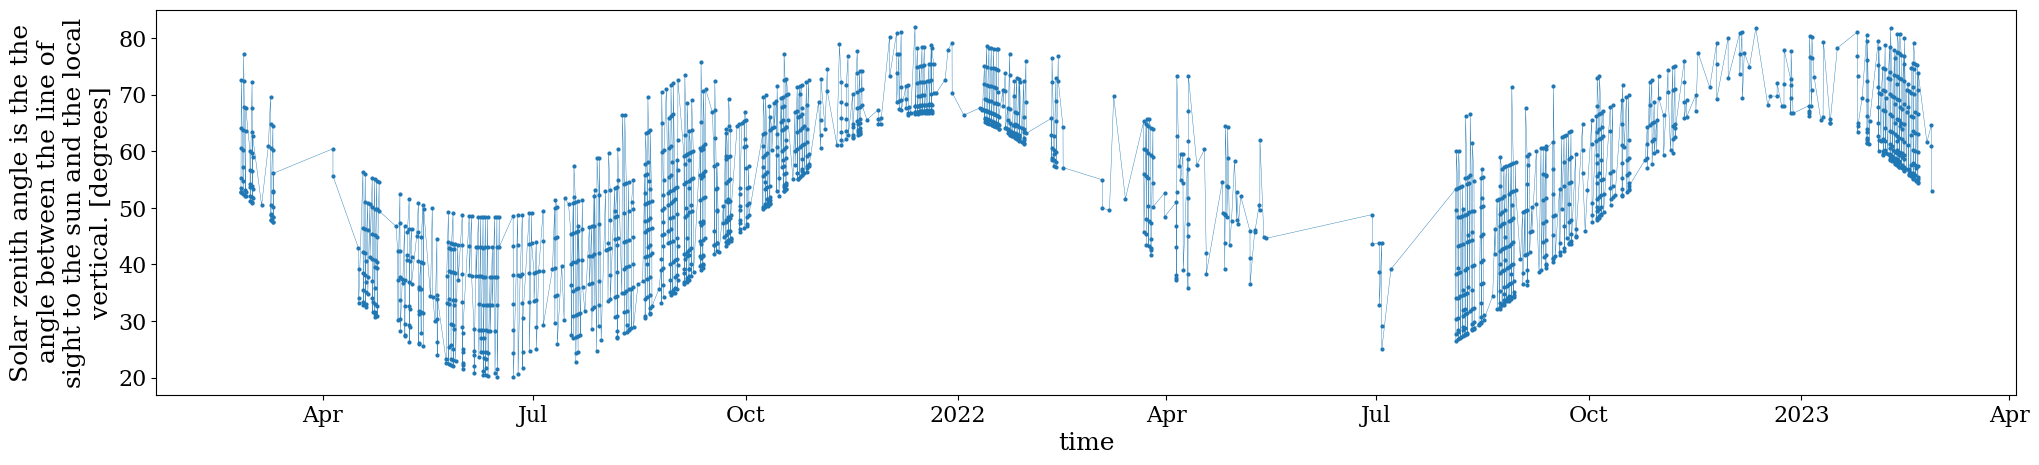

In [4]:

plt.figure(figsize=(24,5))
hypernets.solar_zenith_angle.plot(marker='o',ms=2,lw=0.3)


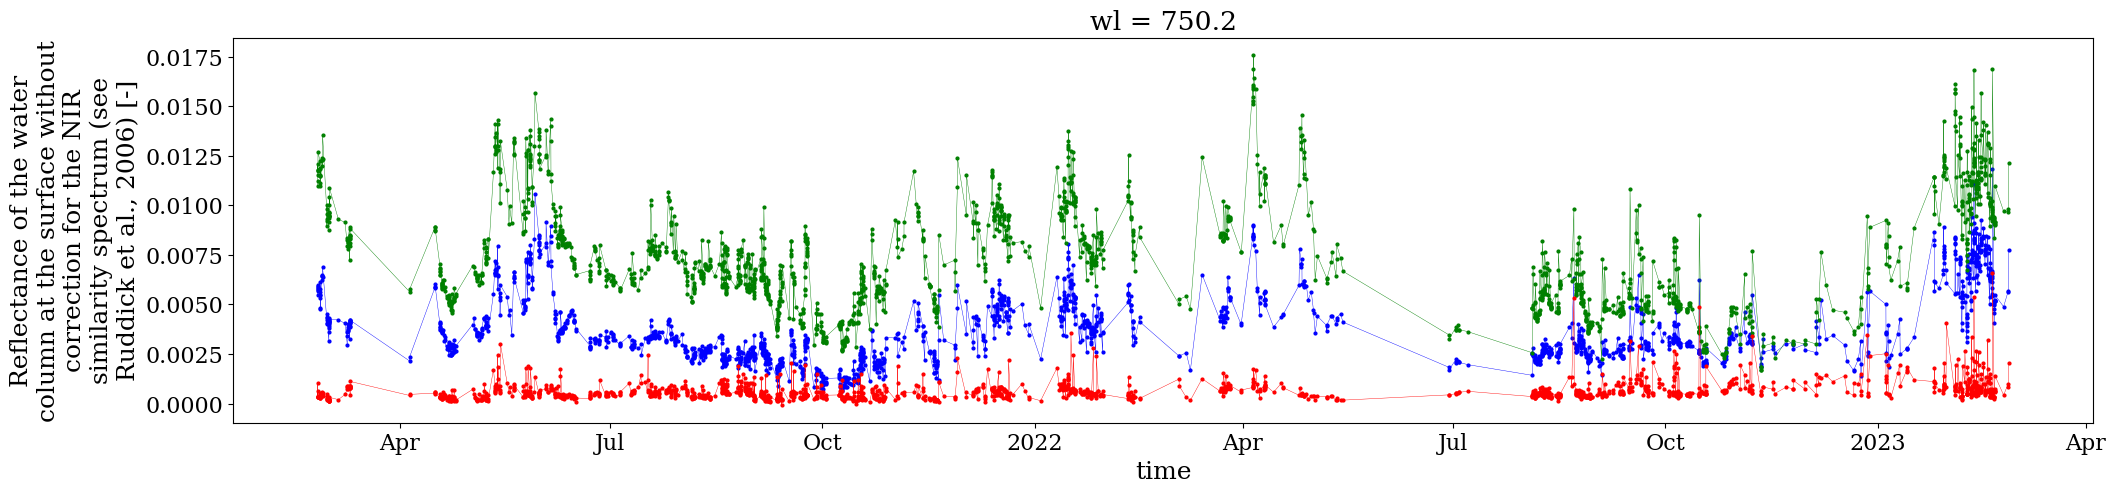

In [5]:

plt.figure(figsize=(24,5))
hypernets.Rrs.sel(wl=450,method='nearest').plot(marker='o',ms=2,lw=0.3,color='blue')
hypernets.Rrs.sel(wl=550,method='nearest').plot(marker='o',ms=2,lw=0.3,color='green')
hypernets.Rrs.sel(wl=750,method='nearest').plot(marker='o',ms=2,lw=0.3,color='red')


## Create datacube

In [6]:
rootdir ='/data/satellite/Sentinel-2/L2A_FR2030/'
dcdir = '/data/satellite/Sentinel-2/subset/hypernets/datacube/'
tile=site
suffix='_matchup'
start_year,end_year=2018,2024

In [7]:
file = "/data/satellite/Sentinel-2/L2A_FR2030/2021/03/13/S2_L2A_20210313T104021_T31TFJ_20250307T131449_v01_00_01.SAFE/S2_L2A_20210313T104021_T31TFJ_20250307T131449_v01_00_01.zarr" 
l2a_prod = xr.open_zarr(file,decode_coords='all')
l2a_prod

<xarray.Dataset> Size: 486MB
Dimensions:             (y: 1830, x: 1830, wl: 11)
Coordinates:
    band                int64 8B ...
    central_wavelength  (wl) float32 44B dask.array<chunksize=(11,), meta=np.ndarray>
    spatial_ref         int64 8B ...
    time                datetime64[ns] 8B ...
  * wl                  (wl) int64 88B 443 490 560 665 705 ... 842 865 1610 2190
  * x                   (x) float64 15kB 6e+05 6.001e+05 ... 7.097e+05 7.098e+05
  * y                   (y) float64 15kB 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
Data variables:
    BRDFg               (y, x) float64 27MB dask.array<chunksize=(458, 458), meta=np.ndarray>
    Rrs                 (wl, y, x) float64 295MB dask.array<chunksize=(3, 458, 458), meta=np.ndarray>
    aot550              (y, x) float64 27MB dask.array<chunksize=(458, 458), meta=np.ndarray>
    dem                 (y, x) float64 27MB dask.array<chunksize=(458, 458), meta=np.ndarray>
    flags               (y, x) int64 27MB dask.array<chunksize=(229, 458), meta=np.ndarray>
    mask                (y, x) uint8 3MB dask.array<chunksize=(458, 915), meta=np.ndarray>
    raa                 (y, x) float64 27MB dask.array<chunksize=(458, 458), meta=np.ndarray>
    sza                 (y, x) float64 27MB dask.array<chunksize=(458, 458), meta=np.ndarray>
    vza                 (y, x) float64 27MB dask.array<chunksize=(458, 458), meta=np.ndarray>
Attributes: (12/72)
    CLOUD_COVERAGE_ASSESSMENT:           60.244339339908294
    DATATAKE_1_DATATAKE_SENSING_START:   2021-03-13T10:40:21.024Z
    DATATAKE_1_DATATAKE_TYPE:            INS-NOBS
    DATATAKE_1_ID:                       GS2A_20210313T104021_029892_N05.00
    DATATAKE_1_SENSING_ORBIT_DIRECTION:  DESCENDING
    DATATAKE_1_SENSING_ORBIT_NUMBER:     8
    ...                                  ...
    sunglint_threshold:                  0.2
    tile:                                31TFJ
    version:                             2.1.7
    vis_swir_index_threshold:            0.0
    water_vapor_transmittance_file:      /usr/local/lib/python3.10/dist-packa...
    wl_to_process:                       [443, 490, 560, 665, 705, 740, 783, ...

In [11]:
v=visual.ViewSpectral(l2a_prod.Rrs.where(l2a_prod.mask==0),reproject=True)
v.minmax=[0,0.1]
v.minmaxvalues=(0,0.04)
v.visu()

Column
    [0] WidgetBox
        [0] Markdown(str)
        [1] Column
            [0] Row
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[0, 1, 2, 3, 4, ...], value=2)
            [1] Row
                [0] Row
                    [0] Markdown(str)
                    [1] DatePicker(enabled_dates=[datetime.date(2021, ...], start=datetime.date(2021, ..., value=datetime.date(2021, ...)
                [1] Row
                    [0] Markdown(str)
                    [1] Select(options=['CartoDark', ...], value='CartoDark')
            [2] Row
                [0] Row
                    [0] Markdown(str)
                    [1] EditableRangeSlider(end=0.1, name='Range Slider', step=0.0001, value=(0, 0.04), width=300)
                [1] Row
                    [0] Markdown(str)
                    [1] FloatSlider(name='Opacity', step=0.05, value=0.95)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(options=['CET_D13', 'bky', ...], value='CET_D13')
        [2] HoloViews(DynamicMap, height=800, sizing_mode='fixed', width=1200)

In [41]:
# subset from center location and width/height

height,width=750,750
clon,clat=hypernets.attrs['site_longitude'], hypernets.attrs['site_latitude']   
ust = grstbx.SpatioTemp()
box = ust.wktbox(clon, clat, width=width, height=height, ellps='WGS84')
bbox = gpd.GeoSeries.from_wkt([box]).set_crs(epsg=4326)

In [42]:
#"/S2_L2A_20210313T104021_T31TFJ_20250307T131449_v01_00_01.zarr""
rootdir='/data/satellite/Sentinel-2/L2A_FR2030'
pattern='*zarr'
datadir = opj(rootdir, '*', '*', '*','*', pattern)#,'*[0-9].nc')
list_files = glob.glob(datadir)
list_files

['/data/satellite/Sentinel-2/L2A_FR2030/2021/03/18/S2_L2A_20210318T103649_T31TFJ_20250307T132013_v01_00_01.SAFE/S2_L2A_20210318T103649_T31TFJ_20250307T132013_v01_00_01.zarr',
 '/data/satellite/Sentinel-2/L2A_FR2030/2021/03/28/S2_L2A_20210328T103629_T31TFJ_20250307T132633_v01_00_01.SAFE/S2_L2A_20210328T103629_T31TFJ_20250307T132633_v01_00_01.zarr',
 '/data/satellite/Sentinel-2/L2A_FR2030/2021/03/10/S2_L2A_20210310T103021_T31TFJ_20250307T131448_v01_00_01.SAFE/S2_L2A_20210310T103021_T31TFJ_20250307T131448_v01_00_01.zarr',
 '/data/satellite/Sentinel-2/L2A_FR2030/2021/03/15/S2_L2A_20210315T102709_T31TFJ_20250307T132012_v01_00_01.SAFE/S2_L2A_20210315T102709_T31TFJ_20250307T132012_v01_00_01.zarr',
 '/data/satellite/Sentinel-2/L2A_FR2030/2021/03/25/S2_L2A_20210325T102639_T31TFJ_20250307T132632_v01_00_01.SAFE/S2_L2A_20210325T102639_T31TFJ_20250307T132632_v01_00_01.zarr',
 '/data/satellite/Sentinel-2/L2A_FR2030/2021/03/13/S2_L2A_20210313T104021_T31TFJ_20250307T131449_v01_00_01.SAFE/S2_L2A_202103

In [43]:
file_labels=['satellite','level','time','tile','processing_time',"version",'subversion','_']
indexes = ['time','satellite','tile','level','processing_time',"version",'subversion','_']
basenames = pd.Series([os.path.basename(p) for p in list_files])  # ,columns=['basename']) #basenames
df = basenames.str.split('_', expand=True)
df.columns=file_labels
df['path']=list_files
df['time'] = pd.to_datetime(df['time'])
df=df.set_index(indexes).sort_index(level=0)
df

path
time                satellite tile   level processing_time version subversion _                                                         
2021-03-03 10:40:21 S2        T31TFJ L2A   20250307T130743 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-05 10:28:09 S2        T31TFJ L2A   20250307T130741 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-08 10:37:59 S2        T31TFJ L2A   20250307T131447 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-10 10:30:21 S2        T31TFJ L2A   20250307T131448 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-13 10:40:21 S2        T31TFJ L2A   20250307T131449 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-15 10:27:09 S2        T31TFJ L2A   20250307T132012 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-18 10:36:49 S2        T31TFJ L2A   20250307T132013 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-20 10:30:21 S2        T31TFJ L2A   20250307T132014 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-23 10:40:21 S2        T31TFJ L2A   20250307T132631 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-25 10:26:39 S2        T31TFJ L2A   20250307T132632 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...
2021-03-28 10:36:29 S2        T31TFJ L2A   20250307T132633 v01     00         01.zarr  /data/satellite/Sentinel-2/L2A_FR2030/2021/03/...

In [44]:

start_date='2018-01-01'
end_date='2024-12-31'
files = df[start_date:end_date].values.ravel()
dc_path=opj(dcdir,tile+f'_{start_date}_{end_date}'+suffix+'.nc')
#if not os.path.exists(dc_path):
dc = grstbx.L2grs(files)
dc.get_l2a_datacube(subset=bbox)
    
    #dc.datacube.to_netcdf(dc_path)

In [45]:
#dcube=xr.open_dataset(dc_path,decode_coords='all')
#dcube

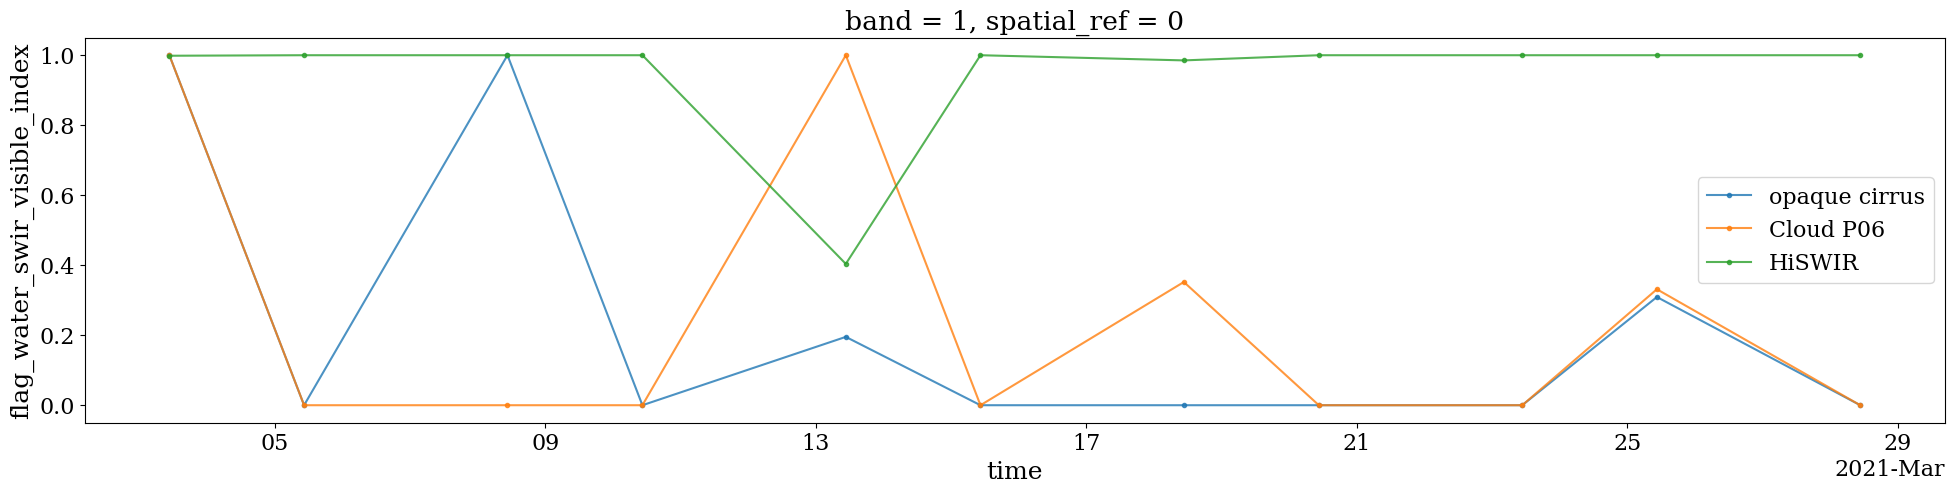

In [46]:
dcube=dc.datacube
alpha=0.8
plt.figure(figsize=(24,5))
dcube.flag_opac_cirrus.plot(marker="o",ms=3,alpha=alpha,label='opaque cirrus')
dcube.flag_cloud_p06.plot(marker="o",ms=3,alpha=alpha,label='Cloud P06')
dcube.flag_water_swir_visible_index.plot(marker="o",ms=3,alpha=alpha,label='HiSWIR')
plt.legend()

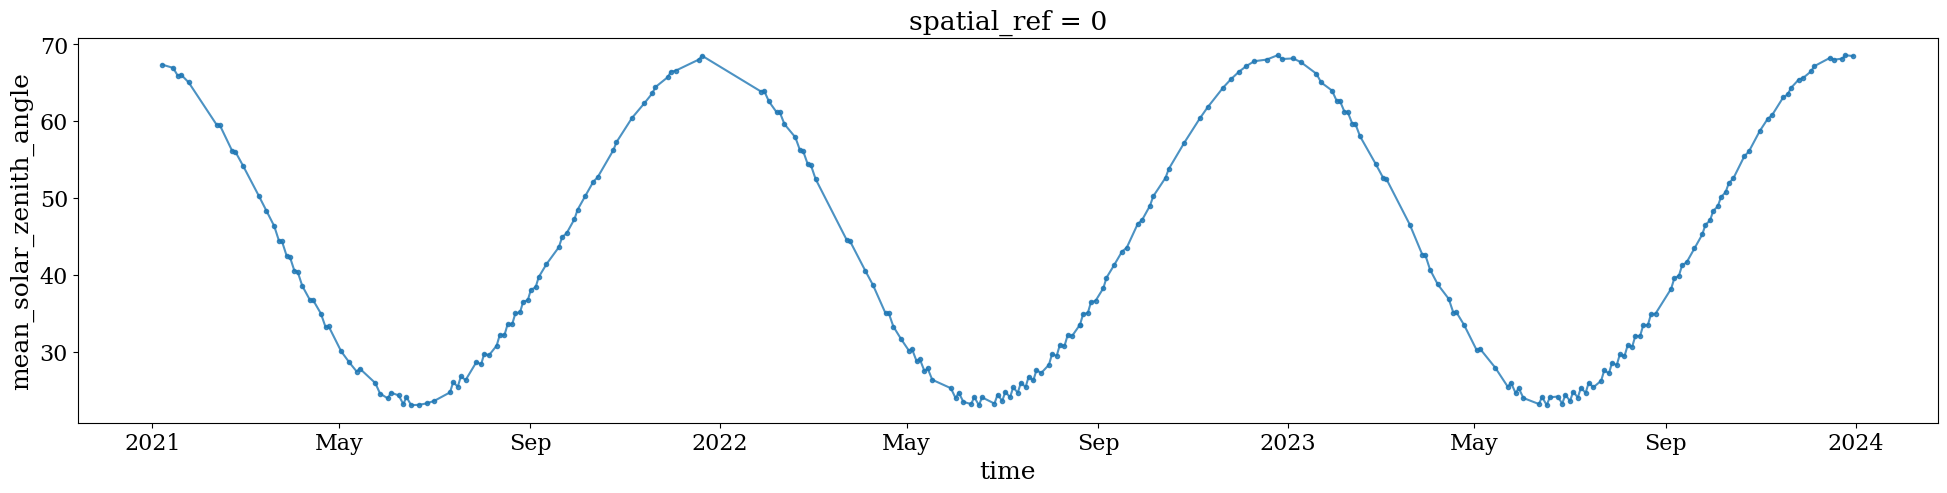

In [15]:
plt.figure(figsize=(24,5))
#dc.datacube.mean_solar_azimuth.plot()
dcube.mean_solar_zenith_angle.plot(marker="o",ms=3,alpha=alpha,label='SZA (deg)')



/home/harmel/anaconda3/envs/py12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


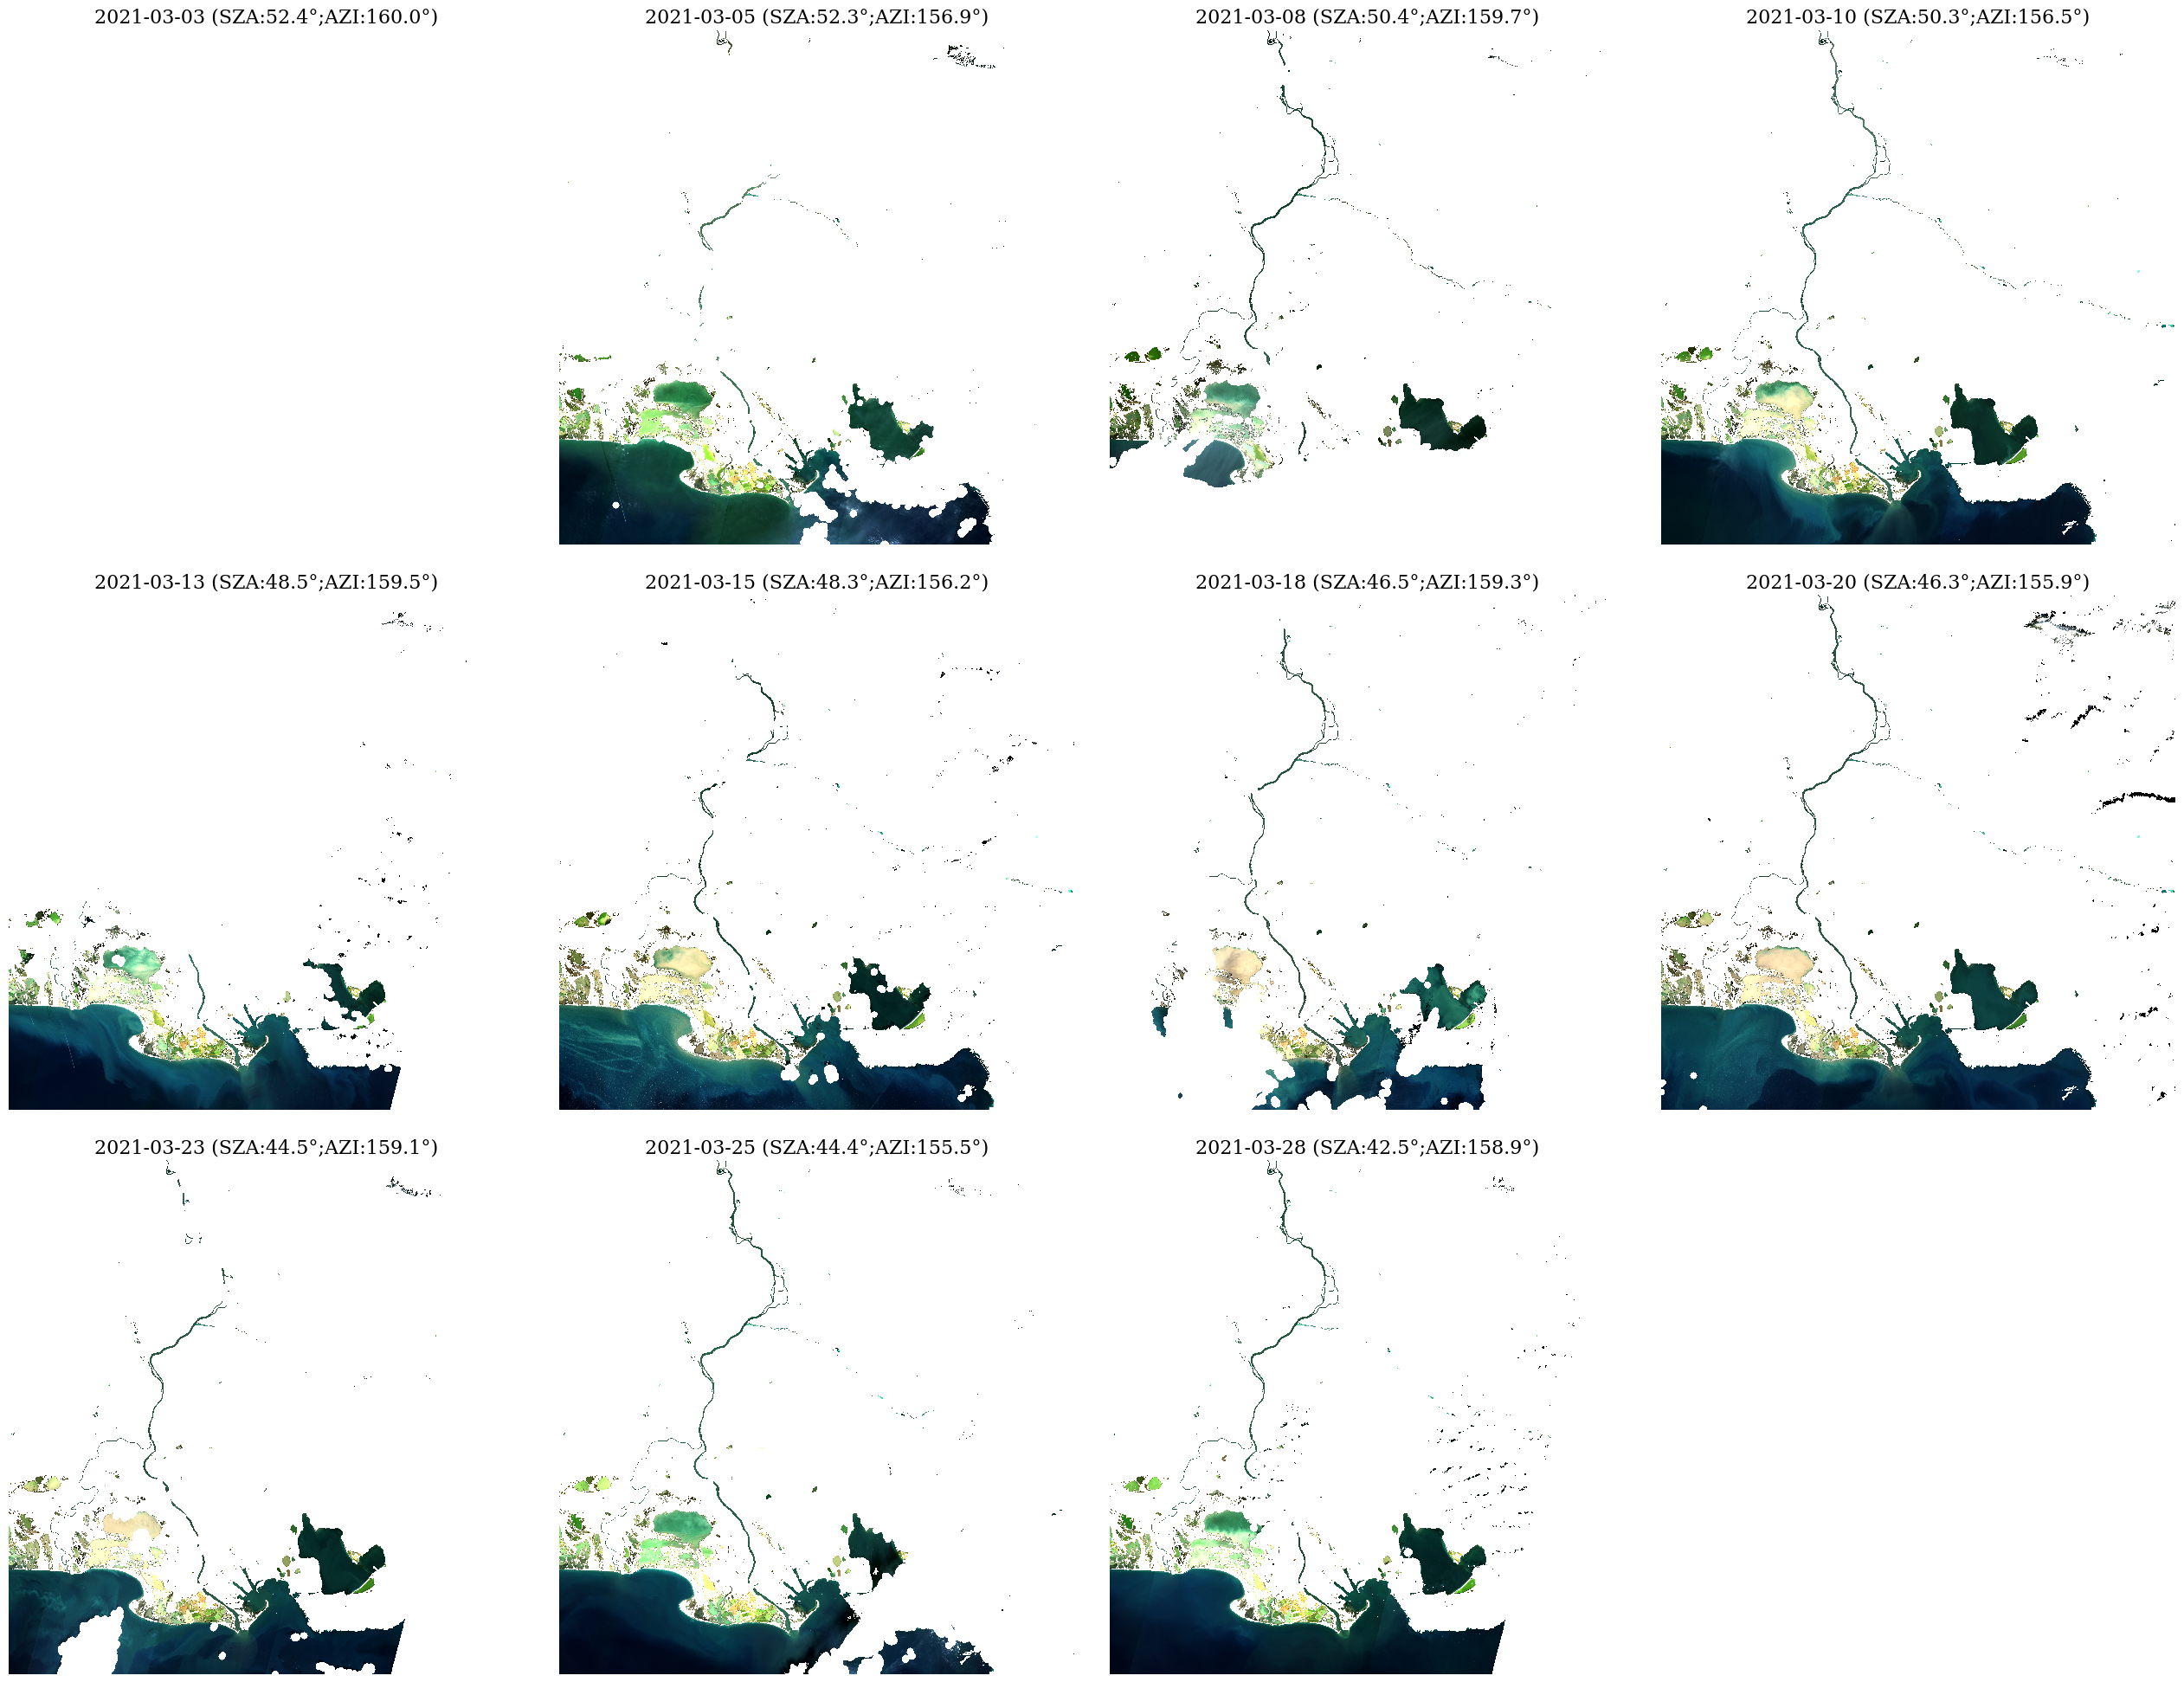

In [35]:
#dcube = dc.datacube

ncols=4


str_epsg = str(dcube.rio.crs)
zone = str_epsg[-2:]
is_south = str_epsg[2] == 7
proj = ccrs.UTM(zone, is_south)
alpha=0.5
dates = dcube.time

Ndates = len(dates)
ncols=np.min([ncols,Ndates])
nrows=int(np.ceil(Ndates/ncols))    

fig,axs = plt.subplots(nrows,ncols,figsize=(ncols*7,7*nrows+2.5),subplot_kw={'projection': proj}) 
fig.subplots_adjust(bottom=0.08, top=0.9, left=0.086, right=0.98,
                    hspace=0.05, wspace=0.07,)
if (ncols == 1) & (nrows == 1):
    axs = np.array([axs])
axs=axs.ravel()
[axi.set_axis_off() for axi in axs]

dem = dcube.dem
for ii,date in enumerate(dates):
    raster = dcube.sel(time=date)
    if 'time' in raster.dims:
        raster=raster.mean('time')
    azi =float(raster.mean_solar_azimuth)
    sza=float(raster.mean_solar_zenith_angle)
  
    date_ = date.dt.strftime('%Y-%m-%d').values
    #print(date_)
    #dem_attrs = grstbx.Dem.compute_dem_attributes(dem,sza,azi)
    #dem_attrs.shaded.plot.imshow(ax=axs[ii],robust=True,cmap=plt.cm.Greys_r,vmax=0.75,add_colorbar=False)#,cbar_kwargs={'shrink':0.4})
    
    raster.Rrs.sel(wl=[665,560,490]).where(raster.mask==0).plot.imshow(ax=axs[ii],rgb='wl', robust=True)
   
    axs[ii].set_title(date_+' (SZA:{:.1f}°;AZI:{:.1f}°)'.format(sza,azi),fontsize=16)


<Figure size 1500x1500 with 0 Axes>

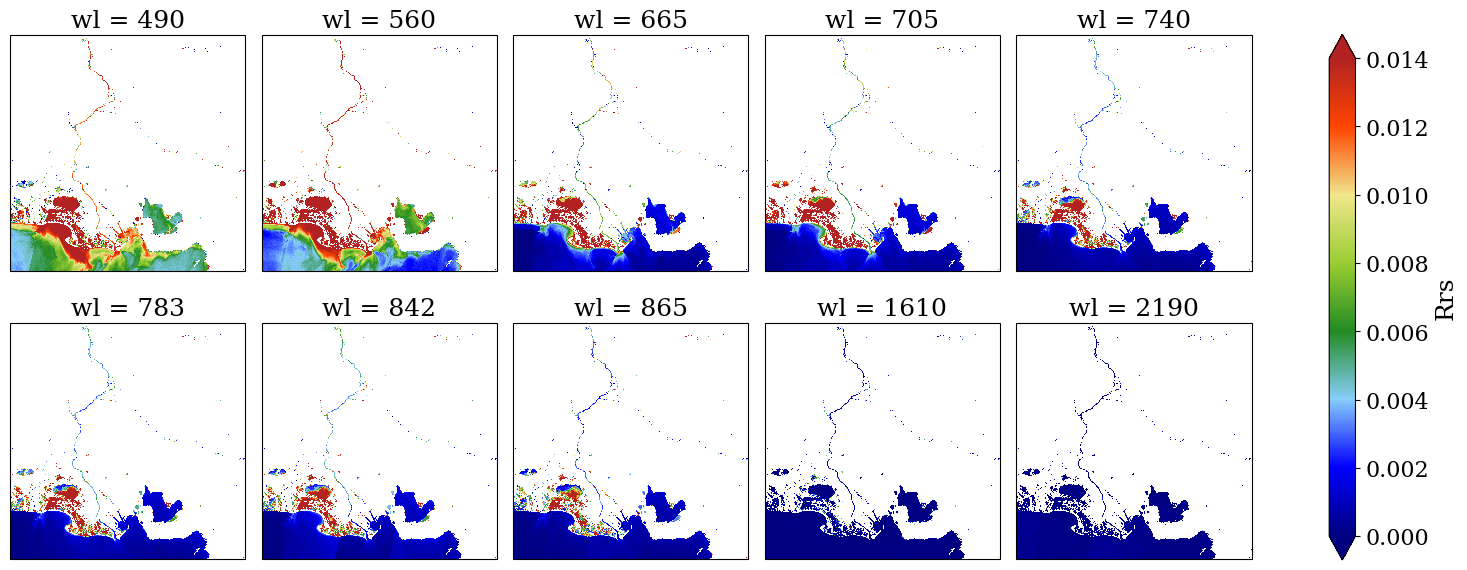

In [38]:
raster = dc.datacube.isel(time=3)
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("",
                                                    ['navy', "blue", 'lightskyblue',
                                                       'forestgreen','yellowgreen',
                                                     "khaki",# "gold",
                                                     'orangered', 
                                                     "firebrick"])
plt.figure(figsize=(15,15))
raster.Rrs.where(raster.mask==0).isel(wl=slice(1,12)).plot.imshow(col='wl',col_wrap=5, cmap=cmap, robust=True,subplot_kws=dict(projection=proj),vmin=-0.00,vmax=0.014)

In [39]:
dcube=dcube.drop_duplicates('time')

In [40]:
v=visual.ViewSpectral(dcube.Rrs,reproject=True)
v.minmax=[0,0.1]
v.visu()

KeyboardInterrupt: 

In [19]:
#geom_ = v.get_geom(v.aoi_stream,crs=dcube.rio.crs)

#Rrs_clipped = dcube.Rrs.sel(wl=slice(400,1000)).where(dcube.mask==0).rio.clip(geom_.geometry.values)

In [47]:
dcube=dcube.drop_duplicates('time')
Rrs_clipped = dcube.Rrs.sel(wl=slice(400,1000)).where(dcube.mask==0)

In [67]:
stacked = Rrs_clipped.sel(wl=slice(400,1000)).dropna('time',thresh=0).stack(gridcell=["y", "x"]).dropna('gridcell',thresh=0).compute()
Npix_tot = len(stacked.gridcell)

group_coord ='wl'

stat_coord='gridcell'
time=stacked.time
date=time.dt.floor('1D')
stats = xr.Dataset({'Rrs_median':stacked.groupby(group_coord).median(stat_coord)},
                  coords={'date':date})
stats['Rrs_q25'] = stacked.groupby(group_coord).quantile(0.25,dim=stat_coord)
stats['Rrs_q75'] = stacked.groupby(group_coord).quantile(0.75,dim=stat_coord)
stats['Rrs_min'] = stacked.groupby(group_coord).min(stat_coord)
stats['Rrs_max'] = stacked.groupby(group_coord).max(stat_coord)
stats['Rrs_mean'] = stacked.groupby(group_coord).mean(stat_coord)
stats['Rrs_std'] = stacked.groupby(group_coord).std(stat_coord)
stats['sza'] = dcube.sza.mean('x').mean('y')
stats['aot550'] = dcube.aot550.mean('x').mean('y')
stats['pix_num'] = stacked.count(stat_coord)
stats['rel_pix_num'] =  stats['pix_num'] / Npix_tot
stats['time'] = time
sat_matchup=stats.swap_dims({'time':'date'}).reset_coords('time')

### Normalized in situ Rrs at nadir view and generate the matchup data set

In [49]:
dir_norms= xr.open_dataarray('/DATA/hypernets/dir_norm.nc')
dir_norms=dir_norms.interp(wl=hypernets.wl)
dir_norms

<xarray.DataArray (sza: 75, wl: 1019)> Size: 611kB
array([[       nan,        nan,        nan, ..., 1.12847031, 1.12863078,
        1.12879452],
       [       nan,        nan,        nan, ..., 1.12489841, 1.12505604,
        1.12521688],
       [       nan,        nan,        nan, ..., 1.1213371 , 1.1214919 ,
        1.12164986],
       ...,
       [       nan,        nan,        nan, ..., 0.87968035, 0.87967609,
        0.87967175],
       [       nan,        nan,        nan, ..., 0.87815226, 0.87814691,
        0.87814144],
       [       nan,        nan,        nan, ..., 0.87664079, 0.87663433,
        0.87662775]])
Coordinates:
    var      <U4 16B 'bb_a'
    level    int64 8B 1
    model    <U8 32B 'grow_pow'
  * sza      (sza) int64 600B 5 6 7 8 9 10 11 12 13 ... 72 73 74 75 76 77 78 79
    azi      int64 8B 90
    dataset  <U15 60B 'Ciotti2002_Sf03'
  * wl       (wl) float64 8kB 399.8 400.3 400.8 401.2 ... 898.4 898.9 899.4

In [50]:
stat

NameError: name 'stat' is not defined

In [51]:

hypernets['Rrs_nadir']=dir_norms.interp(sza=hypernets.solar_zenith_angle)*hypernets[insitu_param]
insitu_data= hypernets
insitu_data

<xarray.Dataset> Size: 153MB
Dimensions:                     (time: 1876, wl: 1019)
Coordinates:
  * wl                          (wl) float64 8kB 399.8 400.3 ... 898.9 899.4
  * time                        (time) datetime64[ns] 15kB 2021-02-24T11:33:4...
    var                         <U4 16B 'bb_a'
    level                       int64 8B 1
    model                       <U8 32B 'grow_pow'
    azi                         int64 8B 90
    dataset                     <U15 60B 'Ciotti2002_Sf03'
    sza                         (time) float64 15kB 52.88 52.76 ... 60.9 52.97
Data variables: (12/20)
    bandwidth                   (time, wl) float64 15MB ...
    viewing_azimuth_angle       (time) float64 15kB ...
    viewing_zenith_angle        (time) float64 15kB ...
    solar_azimuth_angle         (time) float64 15kB ...
    solar_zenith_angle          (time) float64 15kB 52.88 52.76 ... 60.9 52.97
    acquisition_time            (time) float64 15kB ...
    ...                          ...
    reflectance_std             (time, wl) float64 15MB ...
    water_leaving_radiance_std  (time, wl) float64 15MB ...
    reflectance_nosc_std        (time, wl) float64 15MB ...
    Rrs                         (time, wl) float64 15MB ...
    Rrs_corr                    (time, wl) float64 15MB 0.003861 ... 8.443e-05
    Rrs_nadir                   (time, wl) float64 15MB nan nan ... 7.789e-05
Attributes: (12/55)
    type:                             dataset
    abstract:                         The HYPERNETS project (Horizon 2020 res...
    conventions:                      CFv72, NVS2.0
    format_version:                   v01.0
    netcdf_version:                   1.6
    processor_name:                   hypernets_processor
    ...                               ...
    lineage:                          Quality assured following automated thr...
    creator_name:                     Clémence Goyens (RBINS, OD Nature, REMSEM)
    creator_email:                    https://waterhypernet.org/contact/
    history:                          Reflectance is computed by measuring th...
    site_manager:                     David Doxaran (SU, LOV, France)
    site_manager_email:               david.doxaran@imev-mer.fr

In [59]:
import warnings
warnings.filterwarnings('ignore')

times = np.unique(sat_matchup.time.values)

delta_time =  np.timedelta64(2, 'h')

insitu_stats=[]
params=['Rrs_corr','Rrs_nadir']

stats=[]
for iax,time in enumerate(times):
    
    insitu_=insitu_data.sel(time=slice(time-delta_time,time+delta_time))
    
    if len(insitu_.time)==0:
        continue
    #print(time)
   
    time=insitu_.time.mean()
    date=time.dt.floor('1D').values
    stat = xr.Dataset( coords={'date':date})
    for param in params:
    
        stat['is'+param+'_median'] = insitu_[param].median('time')

        stat['is'+param+'_q25'] = insitu_[param].quantile(0.25,dim='time')
        stat['is'+param+'_q75'] = insitu_[param].quantile(0.75,dim='time')
        stat['is'+param+'_min'] = insitu_[param].min('time')
        stat['is'+param+'_max'] = insitu_[param].max('time')
        stat['is'+param+'_mean'] = insitu_[param].mean('time')
        stat['is'+param+'_std'] = insitu_[param].std('time')
    #stat=stat.swap_dims({'time':'date'}).reset_coords('time')

    stats.append(stat)
insitu_stats=xr.concat(stats,dim='date')

    #plt.show()

In [60]:
insitu_stats

<xarray.Dataset> Size: 351kB
Dimensions:             (date: 3, wl: 1019)
Coordinates:
  * date                (date) datetime64[ns] 24B 2021-03-05 ... 2021-03-10
  * wl                  (wl) float64 8kB 399.8 400.3 400.8 ... 898.4 898.9 899.4
    var                 <U4 16B 'bb_a'
    level               int64 8B 1
    model               <U8 32B 'grow_pow'
    azi                 int64 8B 90
    dataset             <U15 60B 'Ciotti2002_Sf03'
    quantile            float64 8B 0.25
Data variables: (12/14)
    isRrs_corr_median   (date, wl) float64 24kB 0.003264 0.003282 ... 5.359e-05
    isRrs_corr_q25      (date, wl) float64 24kB 0.003264 0.003282 ... 4.876e-05
    isRrs_corr_q75      (date, wl) float64 24kB 0.003264 0.003282 ... 6.613e-05
    isRrs_corr_min      (date, wl) float64 24kB 0.003264 0.003282 ... 4.065e-05
    isRrs_corr_max      (date, wl) float64 24kB 0.003264 0.003282 ... 7.294e-05
    isRrs_corr_mean     (date, wl) float64 24kB 0.003264 0.003282 ... 5.637e-05
    ...                  ...
    isRrs_nadir_q25     (date, wl) float64 24kB nan nan ... 4.322e-05 4.551e-05
    isRrs_nadir_q75     (date, wl) float64 24kB nan nan ... 6.242e-05 6.081e-05
    isRrs_nadir_min     (date, wl) float64 24kB nan nan ... 2.275e-05 3.797e-05
    isRrs_nadir_max     (date, wl) float64 24kB nan nan ... 7.263e-05 6.569e-05
    isRrs_nadir_mean    (date, wl) float64 24kB nan nan ... 4.981e-05 5.185e-05
    isRrs_nadir_std     (date, wl) float64 24kB nan nan ... 1.641e-05 9.988e-06

In [61]:
insitu_matchup = insitu_stats.interp(wl=sat_matchup.wl)
matchup_data = xr.merge([sat_matchup,insitu_matchup],join="inner")#, join="override")
matchup_data

<xarray.Dataset> Size: 5kB
Dimensions:             (wl: 9, date: 3)
Coordinates:
  * wl                  (wl) int64 72B 443 490 560 665 705 740 783 842 865
  * date                (date) datetime64[ns] 24B 2021-03-05 ... 2021-03-10
    band                int64 8B 1
    central_wavelength  (date, wl) float32 108B 442.2 492.4 ... 832.8 864.7
    spatial_ref         int64 8B 0
    quantile            float64 8B 0.25
    var                 <U4 16B 'bb_a'
    level               int64 8B 1
    model               <U8 32B 'grow_pow'
    azi                 int64 8B 90
    dataset             <U15 60B 'Ciotti2002_Sf03'
Data variables: (12/26)
    time                (date) datetime64[ns] 24B 2021-03-05T10:28:09 ... 202...
    Rrs_median          (date, wl) float64 216B 0.00459 0.00679 ... 0.00072
    Rrs_q25             (date, wl) float64 216B 0.00421 0.00646 ... 0.00064
    Rrs_q75             (date, wl) float64 216B 0.005012 0.00715 ... 0.0008
    Rrs_min             (date, wl) float64 216B 0.00334 0.00562 ... 0.00036
    Rrs_max             (date, wl) float64 216B 0.00666 0.00876 ... 0.00111
    ...                  ...
    isRrs_nadir_q25     (date, wl) float64 216B 0.003688 0.005576 ... 9.751e-05
    isRrs_nadir_q75     (date, wl) float64 216B 0.003688 0.005576 ... 0.0001104
    isRrs_nadir_min     (date, wl) float64 216B 0.003688 0.005576 ... 8.783e-05
    isRrs_nadir_max     (date, wl) float64 216B 0.003688 0.005576 ... 0.000115
    isRrs_nadir_mean    (date, wl) float64 216B 0.003688 0.005576 ... 0.0001032
    isRrs_nadir_std     (date, wl) float64 216B 0.0 0.0 ... 7.443e-06 9.349e-06

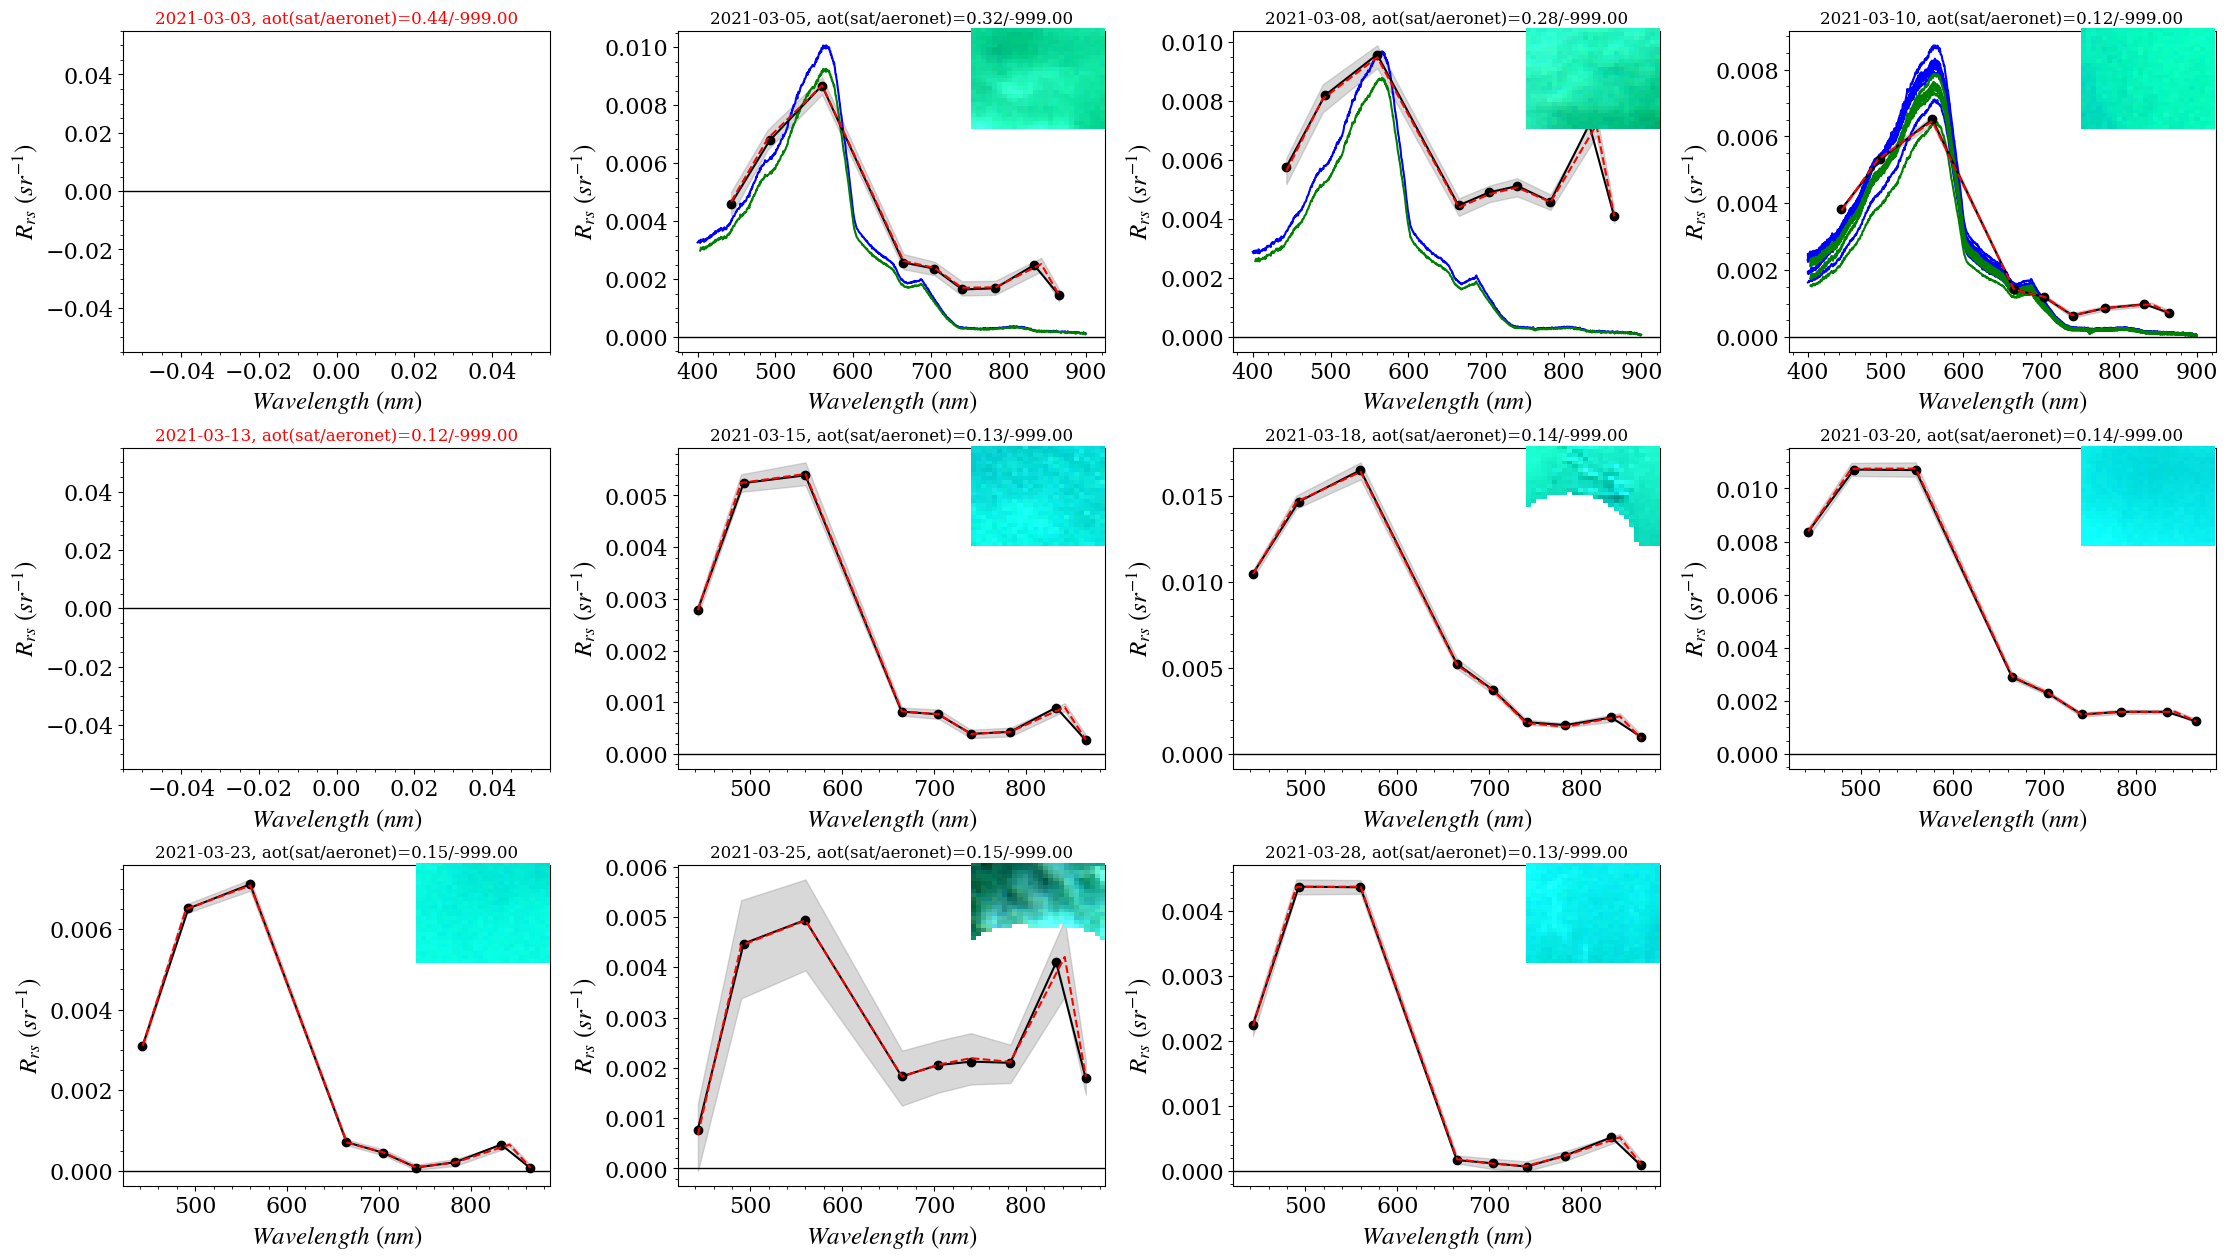

In [68]:
delta_time =  np.timedelta64(4, 'h')
wl_true = [ 442.69104,  492.72842,  559.85376,  664.6208 ,  704.12225,
        740.4838 ,  782.751  ,  832.789  ,  864.7106 ]
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
num_items = len(stats.time)
col_wrap=4
rows=int(np.ceil(num_items/col_wrap))
bands=[3,2,1]

fig, axs = plt.subplots(nrows=rows,ncols=col_wrap, sharex=False, figsize=(col_wrap*6+3, rows*5))#,sharey=True
fig.subplots_adjust(hspace=0.3,wspace=0.3)
axs_ = axs.ravel()
[axi.set_axis_off() for axi in axs_]
for iax,(time_,group) in enumerate(stats.groupby('time')): 
    group=group.squeeze()
    if iax > 12000:
        break
    color='black'
    if group['rel_pix_num'].isel(wl=2).squeeze()<0.5:
        color='red'
    
    date_= str(group.time.dt.strftime('%Y-%m-%d').values)
    
    axs_[iax].set_axis_on()
    axs_[iax].minorticks_on()
    date = group.time.dt.date.values
    #spm = float(insitu_data.sel(time=date,method='nearest').spm)
    axins = inset_axes(axs_[iax], width="25%", height="25%",
                   bbox_to_anchor=(.66, .66, 1.25, 1.25),
                   bbox_transform=axs_[iax].transAxes, loc=3)
    try:
       
        hyp_ = (hypernets.sel(time=slice(time_-delta_time,time_+delta_time)))
        hyp_.Rrs_corr.plot(hue='time',color='blue',ax=axs_[iax],add_legend=False)
        dir_corr=dir_norms.interp(sza=hyp_.solar_zenith_angle)
        
        (dir_corr*hyp_.Rrs_corr).plot(hue='time',color='green',ax=axs_[iax],add_legend=False)
        
    except:
        aot_aeronet = -999
    Rrs_clipped.sel(time=time_).isel(wl=bands).plot.imshow(robust=True,ax=axins)
    axins.set_title('')
    axins.set_axis_off()
    axs_[iax].axhline(y=0,color='k',lw=1)
    axs_[iax].plot(wl_true,group['Rrs_median'],c='k',marker='o')
    axs_[iax].plot(group.wl,group['Rrs_mean'],c='red',ls='--')
    axs_[iax].fill_between(group.wl, group['Rrs_q25'], group['Rrs_q75'],alpha=0.3,color='grey')
    axs_[iax].set_title(str(date)+', aot(sat/aeronet)={:.2f}/{:.2f}'.format(group['aot550'].values,aot_aeronet),color=color,fontsize=12)#+', 
    axs_[iax].set_xlabel(r'$Wavelength\ (nm)$')
    axs_[iax].set_ylabel(r'$R_{rs}\ (sr^{-1})$')
plt.show()

In [56]:
good_dates = stats.where(stats.rel_pix_num>0.2,drop=True).time.values

AttributeError: 'list' object has no attribute 'where'

In [57]:
stats.sel(time=good_dates)['median'].plot(hue='time',marker='o',ms=3,color='k',alpha=0.5,add_legend=False)
plt.show()

AttributeError: 'list' object has no attribute 'sel'

In [21]:
stats.where(stats.rel_pix_num>0.2,drop=True)

<xarray.Dataset> Size: 178kB
Dimensions:      (time: 223, wl: 9)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2021-01-14T10:33:09 ... 2023-12-30...
  * wl           (wl) int64 72B 443 490 560 665 705 740 783 842 865
    spatial_ref  int64 8B 0
    quantile     float64 8B 0.25
Data variables:
    median       (time, wl) float64 16kB 0.00115 0.00427 ... 0.00093 0.00065
    Rrs_q25      (time, wl) float64 16kB 0.00099 0.00399 ... 0.00078 0.000385
    Rrs_q75      (time, wl) float64 16kB 0.00132 0.00454 ... 0.00108 0.00088
    Rrs_min      (time, wl) float64 16kB 0.00027 0.00295 ... 0.00018 -0.00077
    Rrs_max      (time, wl) float64 16kB 0.00249 0.00945 ... 0.00162 0.00197
    Rrs_mean     (time, wl) float64 16kB 0.001162 0.004278 ... 0.0006309
    Rrs_std      (time, wl) float64 16kB 0.0002624 0.0004823 ... 0.0003609
    sza          (time, wl) float64 16kB 66.62 66.62 66.62 ... 68.16 68.16 68.16
    aot550       (time, wl) float64 16kB 0.04731 0.04731 ... 0.05904 0.05904
    pix_num      (time, wl) float64 16kB 2.601e+03 2.601e+03 ... 2.583e+03
    rel_pix_num  (time, wl) float64 16kB 1.0 1.0 1.0 ... 0.9931 0.9931 0.9931

In [23]:
sat_time = stats.where(stats.rel_pix_num>0.2,drop=True).time#.reset_coords(drop=True)
sat_time.name = 'sat_time'

insitu_data = hypernets #ds
insitu_time = insitu_data.time
insitu_time.name = 'insitu_time'


In [24]:
matchup_time = pd.merge_asof(
    sat_time.to_dataframe(),
    insitu_time.to_dataframe(),
    tolerance=pd.Timedelta("2h"),left_index=True, right_index=True).dropna()
matchup_time


spatial_ref  quantile            sat_time   var  level  \
time                                                                          
2021-02-28 10:30:21            0      0.25 2021-02-28 10:30:21  bb_a    1.0   
2021-03-10 10:30:21            0      0.25 2021-03-10 10:30:21  bb_a    1.0   
2021-04-19 10:30:21            0      0.25 2021-04-19 10:30:21  bb_a    1.0   
2021-04-22 10:40:21            0      0.25 2021-04-22 10:40:21  bb_a    1.0   
2021-04-24 10:25:49            0      0.25 2021-04-24 10:25:49  bb_a    1.0   
...                          ...       ...                 ...   ...    ...   
2023-02-06 10:41:29            0      0.25 2023-02-06 10:41:29  bb_a    1.0   
2023-02-08 10:32:11            0      0.25 2023-02-08 10:32:11  bb_a    1.0   
2023-02-11 10:41:51            0      0.25 2023-02-11 10:41:51  bb_a    1.0   
2023-02-13 10:30:39            0      0.25 2023-02-13 10:30:39  bb_a    1.0   
2023-02-26 10:39:19            0      0.25 2023-02-26 10:39:19  bb_a    1.0   

                        model   azi          dataset      sza  \
time                                                            
2021-02-28 10:30:21  grow_pow  90.0  Ciotti2002_Sf03  56.7308   
2021-03-10 10:30:21  grow_pow  90.0  Ciotti2002_Sf03  52.9172   
2021-04-19 10:30:21  grow_pow  90.0  Ciotti2002_Sf03  38.1024   
2021-04-22 10:40:21  grow_pow  90.0  Ciotti2002_Sf03  34.0424   
2021-04-24 10:25:49  grow_pow  90.0  Ciotti2002_Sf03  40.4320   
...                       ...   ...              ...      ...   
2023-02-06 10:41:29  grow_pow  90.0  Ciotti2002_Sf03  61.8072   
2023-02-08 10:32:11  grow_pow  90.0  Ciotti2002_Sf03  63.5404   
2023-02-11 10:41:51  grow_pow  90.0  Ciotti2002_Sf03  60.2504   
2023-02-13 10:30:39  grow_pow  90.0  Ciotti2002_Sf03  62.1096   
2023-02-26 10:39:19  grow_pow  90.0  Ciotti2002_Sf03  60.9000   

                            insitu_time  
time                                     
2021-02-28 10:30:21 2021-02-28 10:04:28  
2021-03-10 10:30:21 2021-03-10 10:04:59  
2021-04-19 10:30:21 2021-04-19 10:03:47  
2021-04-22 10:40:21 2021-04-22 10:33:42  
2021-04-24 10:25:49 2021-04-24 09:33:40  
...                                 ...  
2023-02-06 10:41:29 2023-02-06 10:33:46  
2023-02-08 10:32:11 2023-02-08 10:04:30  
2023-02-11 10:41:51 2023-02-11 10:34:25  
2023-02-13 10:30:39 2023-02-13 10:03:39  
2023-02-26 10:39:19 2023-02-26 09:33:58  

[77 rows x 10 columns]

In [25]:
stats.time.dt.floor('1D')

<xarray.DataArray 'floor' (time: 256)> Size: 2kB
array(['2021-01-07T00:00:00.000000000', '2021-01-14T00:00:00.000000000',
       '2021-01-17T00:00:00.000000000', '2021-01-19T00:00:00.000000000',
       '2021-01-24T00:00:00.000000000', '2021-02-11T00:00:00.000000000',
       '2021-02-13T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
       '2021-02-23T00:00:00.000000000', '2021-02-28T00:00:00.000000000',
       '2021-03-10T00:00:00.000000000', '2021-03-15T00:00:00.000000000',
       '2021-03-20T00:00:00.000000000', '2021-03-23T00:00:00.000000000',
       '2021-03-25T00:00:00.000000000', '2021-03-28T00:00:00.000000000',
       '2021-03-30T00:00:00.000000000', '2021-04-02T00:00:00.000000000',
       '2021-04-04T00:00:00.000000000', '2021-04-07T00:00:00.000000000',
       '2021-04-12T00:00:00.000000000', '2021-04-14T00:00:00.000000000',
       '2021-04-19T00:00:00.000000000', '2021-04-22T00:00:00.000000000',
       '2021-04-24T00:00:00.000000000', '2021-05-02T00:00:00.000000000',
       '2021-05-07T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-14T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-27T00:00:00.000000000', '2021-06-01T00:00:00.000000000',
       '2021-06-03T00:00:00.000000000', '2021-06-08T00:00:00.000000000',
       '2021-06-11T00:00:00.000000000', '2021-06-13T00:00:00.000000000',
       '2021-06-16T00:00:00.000000000', '2021-06-21T00:00:00.000000000',
       '2021-06-26T00:00:00.000000000', '2021-07-01T00:00:00.000000000',
...
       '2023-08-12T00:00:00.000000000', '2023-08-15T00:00:00.000000000',
       '2023-08-17T00:00:00.000000000', '2023-08-20T00:00:00.000000000',
       '2023-08-22T00:00:00.000000000', '2023-08-25T00:00:00.000000000',
       '2023-09-04T00:00:00.000000000', '2023-09-06T00:00:00.000000000',
       '2023-09-09T00:00:00.000000000', '2023-09-11T00:00:00.000000000',
       '2023-09-14T00:00:00.000000000', '2023-09-19T00:00:00.000000000',
       '2023-09-24T00:00:00.000000000', '2023-09-26T00:00:00.000000000',
       '2023-09-29T00:00:00.000000000', '2023-10-01T00:00:00.000000000',
       '2023-10-04T00:00:00.000000000', '2023-10-06T00:00:00.000000000',
       '2023-10-09T00:00:00.000000000', '2023-10-11T00:00:00.000000000',
       '2023-10-14T00:00:00.000000000', '2023-10-21T00:00:00.000000000',
       '2023-10-24T00:00:00.000000000', '2023-10-31T00:00:00.000000000',
       '2023-11-05T00:00:00.000000000', '2023-11-08T00:00:00.000000000',
       '2023-11-15T00:00:00.000000000', '2023-11-18T00:00:00.000000000',
       '2023-11-20T00:00:00.000000000', '2023-11-25T00:00:00.000000000',
       '2023-11-28T00:00:00.000000000', '2023-12-03T00:00:00.000000000',
       '2023-12-05T00:00:00.000000000', '2023-12-15T00:00:00.000000000',
       '2023-12-18T00:00:00.000000000', '2023-12-23T00:00:00.000000000',
       '2023-12-25T00:00:00.000000000', '2023-12-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2kB 2021-01-07T10:43:29 ... 2023-12-30...
    spatial_ref  int64 8B 0
    quantile     float64 8B 0.25

In [66]:

def get_daily(ds):
    ds['time'] = ds.time.dt.floor('1D')
    
    # group by 'date' using an average (mean)
    return ds.groupby('time').mean()
get_daily(stats.sel(time=matchup_time['sat_time'].values))

AttributeError: 'list' object has no attribute 'sel'

In [27]:
insitu_data#.interp(wl=xmatchup.wl)

<xarray.Dataset> Size: 153MB
Dimensions:                     (time: 1876, wl: 1019)
Coordinates:
  * wl                          (wl) float64 8kB 399.8 400.3 ... 898.9 899.4
  * time                        (time) datetime64[ns] 15kB 2021-02-24T11:33:4...
    var                         <U4 16B 'bb_a'
    level                       int64 8B 1
    model                       <U8 32B 'grow_pow'
    azi                         int64 8B 90
    dataset                     <U15 60B 'Ciotti2002_Sf03'
    sza                         (time) float64 15kB 52.88 52.76 ... 60.9 52.97
Data variables: (12/20)
    bandwidth                   (time, wl) float64 15MB ...
    viewing_azimuth_angle       (time) float64 15kB ...
    viewing_zenith_angle        (time) float64 15kB ...
    solar_azimuth_angle         (time) float64 15kB ...
    solar_zenith_angle          (time) float64 15kB 52.88 52.76 ... 60.9 52.97
    acquisition_time            (time) float64 15kB ...
    ...                          ...
    reflectance_std             (time, wl) float64 15MB ...
    water_leaving_radiance_std  (time, wl) float64 15MB ...
    reflectance_nosc_std        (time, wl) float64 15MB ...
    Rrs                         (time, wl) float64 15MB ...
    Rrs_corr                    (time, wl) float64 15MB 0.003861 ... 8.443e-05
    Rrs_nadir                   (time, wl) float64 15MB nan nan ... 7.789e-05
Attributes: (12/55)
    type:                             dataset
    abstract:                         The HYPERNETS project (Horizon 2020 res...
    conventions:                      CFv72, NVS2.0
    format_version:                   v01.0
    netcdf_version:                   1.6
    processor_name:                   hypernets_processor
    ...                               ...
    lineage:                          Quality assured following automated thr...
    creator_name:                     Clémence Goyens (RBINS, OD Nature, REMSEM)
    creator_email:                    https://waterhypernet.org/contact/
    history:                          Reflectance is computed by measuring th...
    site_manager:                     David Doxaran (SU, LOV, France)
    site_manager_email:               david.doxaran@imev-mer.fr

In [65]:
xmatchup = get_daily(stats.sel(time=matchup_time['sat_time'].values)) 
xmatchup

NameError: name 'get_daily' is not defined

In [66]:
insitu_matchup = insitu_data.sel(time=matchup_time['insitu_time'].values).load().sortby('wl')
insitu_matchup = get_daily(insitu_matchup.interpolate_na(dim="wl").interp(wl=xmatchup.wl))
insitu_matchup

NameError: name 'matchup_time' is not defined

In [30]:
matchup_data = xr.merge([xmatchup,insitu_matchup])#, join="override")
matchup_data

<xarray.Dataset> Size: 114kB
Dimensions:                     (time: 77, wl: 9)
Coordinates:
  * wl                          (wl) int64 72B 443 490 560 665 ... 783 842 865
    spatial_ref                 int64 8B 0
    quantile                    float64 8B 0.25
  * time                        (time) datetime64[ns] 616B 2021-02-28 ... 202...
    var                         <U4 16B 'bb_a'
    level                       int64 8B 1
    model                       <U8 32B 'grow_pow'
    azi                         int64 8B 90
    dataset                     <U15 60B 'Ciotti2002_Sf03'
Data variables: (12/31)
    median                      (time, wl) float64 6kB 0.00334 ... 0.00104
    Rrs_q25                     (time, wl) float64 6kB 0.00321 ... 0.00076
    Rrs_q75                     (time, wl) float64 6kB 0.00347 ... 0.00135
    Rrs_min                     (time, wl) float64 6kB 0.00272 ... -0.00031
    Rrs_max                     (time, wl) float64 6kB 0.00394 ... 0.00541
    Rrs_mean                    (time, wl) float64 6kB 0.003342 ... 0.001097
    ...                          ...
    reflectance_std             (time, wl) float64 6kB 0.000758 ... 0.0001237
    water_leaving_radiance_std  (time, wl) float64 6kB 0.3008 ... 0.008293
    reflectance_nosc_std        (time, wl) float64 6kB 0.001311 ... 6.213e-05
    Rrs                         (time, wl) float64 6kB 0.003962 ... 0.0006006
    Rrs_corr                    (time, wl) float64 6kB 0.003842 ... 0.0001782
    Rrs_nadir                   (time, wl) float64 6kB 0.003492 ... 0.0001615

In [109]:

import scipy as sp
from sklearn import linear_model, metrics
def add_stats(x, y, ax,
              label=False,
              fontsize=12,
              Nbands=0):
    regr = sp.stats.linregress(x, y)

    # Prediction metrics
    rmse = np.sqrt(metrics.mean_squared_error(x, y))
    mape = metrics.mean_absolute_percentage_error(x, y)
    bias = np.mean(y - x)
    
    #Median symmetric accuracy (eps) (Eq. 8), medianBIAS (beta) Eq. 9 in Pahlevan et al. 2020
    abs_med_ratio=np.median(np.abs(np.log10(y)-np.log10(x)))
    med_ratio=np.median(np.log10(y)-np.log10(x))
    eps=(10**abs_med_ratio-1)
    beta=10**np.abs(med_ratio)
    
    N = len(x)
    stats = r'$y = %.2f x %+.4f$' % (regr.slope, regr.intercept) + \
            '\n$r = %.3f$' % (regr.rvalue) + \
            '\n$rmse = %.4f$' % (rmse) + \
            '\n$mape = %.3f$' % (mape) + \
            '\n$bias = %.4f$' % (bias) + \
            '\n$\\epsilon = %.3f$' % (eps) + \
            '\n$\\beta = %.3f$' % (beta) 
    if Nbands > 0:
        stats+='\n$N = %i(%i)$' % (N,N/Nbands)
    else:
        stats+='\n$N = %i$' % (N)

    #print(stats)
    ax.axline(xy1=(0.01, regr.intercept + 0.01 * regr.slope), slope=regr.slope, ls='--', lw=1.5, c="gray")
    if label:
       # ax.text(0.02, 0.98, stats, fontsize=fontsize, verticalalignment='top', horizontalalignment='left',
       #         transform=ax.transAxes)
        ax.text(0.98, 0.01, stats, fontsize=fontsize, verticalalignment='bottom', horizontalalignment='right',
                    transform=ax.transAxes)
    return


In [110]:
matchup_df =matchup_data.to_dataframe().reset_index('wl') 
matchup_df

wl                time  spatial_ref  Rrs_median  quantile  \
date                                                                     
2021-02-28  443 2021-02-28 10:30:21            0     0.00334      0.25   
2021-03-10  443 2021-03-10 10:30:21            0     0.00255      0.25   
2021-04-19  443 2021-04-19 10:30:21            0     0.00464      0.25   
2021-04-22  443 2021-04-22 10:40:21            0     0.00261      0.25   
2021-04-24  443 2021-04-24 10:25:49            0     0.00124      0.25   
...         ...                 ...          ...         ...       ...   
2023-02-08  865 2023-02-08 10:32:11            0     0.00027      0.25   
2023-02-11  865 2023-02-11 10:41:51            0     0.00043      0.25   
2023-02-13  865 2023-02-13 10:30:39            0     0.00031      0.25   
2023-02-16  865 2023-02-16 10:40:19            0         NaN      0.25   
2023-02-26  865 2023-02-26 10:39:19            0     0.00104      0.25   

            Rrs_q25  Rrs_q75  Rrs_min  Rrs_max  Rrs_mean  ...  \
date                                                      ...   
2021-02-28  0.00321  0.00347  0.00272  0.00394  0.003342  ...   
2021-03-10  0.00247  0.00261  0.00213  0.00288  0.002539  ...   
2021-04-19  0.00458  0.00472  0.00435  0.00497  0.004648  ...   
2021-04-22  0.00249  0.00276  0.00124  0.00356  0.002638  ...   
2021-04-24  0.00118  0.00131  0.00082  0.00155  0.001248  ...   
...             ...      ...      ...      ...       ...  ...   
2023-02-08  0.00006  0.00049 -0.00092  0.00134  0.000273  ...   
2023-02-11  0.00022  0.00060 -0.00061  0.00171  0.000417  ...   
2023-02-13  0.00014  0.00053 -0.00065  0.00126  0.000326  ...   
2023-02-16      NaN      NaN      NaN      NaN       NaN  ...   
2023-02-26  0.00076  0.00135 -0.00031  0.00541  0.001097  ...   

            isRrs_nadir_q75  isRrs_nadir_min  isRrs_nadir_max  \
date                                                            
2021-02-28         0.003520         0.003433         0.003595   
2021-03-10         0.002993         0.002174         0.003085   
2021-04-19         0.003041         0.002952         0.003065   
2021-04-22         0.002478         0.002277         0.002513   
2021-04-24         0.002332         0.002119         0.002454   
...                     ...              ...              ...   
2023-02-08         0.000163         0.000139         0.000186   
2023-02-11         0.000337         0.000270         0.000352   
2023-02-13         0.000290         0.000236         0.000302   
2023-02-16         0.000229         0.000175         0.000268   
2023-02-26         0.000214         0.000161         0.000251   

            isRrs_nadir_mean  isRrs_nadir_std   var  level     model  azi  \
date                                                                        
2021-02-28          0.003500         0.000059  bb_a      1  grow_pow   90   
2021-03-10          0.002806         0.000311  bb_a      1  grow_pow   90   
2021-04-19          0.003014         0.000040  bb_a      1  grow_pow   90   
2021-04-22          0.002396         0.000089  bb_a      1  grow_pow   90   
2021-04-24          0.002260         0.000128  bb_a      1  grow_pow   90   
...                      ...              ...   ...    ...       ...  ...   
2023-02-08          0.000159         0.000014  bb_a      1  grow_pow   90   
2023-02-11          0.000314         0.000028  bb_a      1  grow_pow   90   
2023-02-13          0.000272         0.000026  bb_a      1  grow_pow   90   
2023-02-16          0.000211         0.000032  bb_a      1  grow_pow   90   
2023-02-26          0.000196         0.000040  bb_a      1  grow_pow   90   

                    dataset  
date                         
2021-02-28  Ciotti2002_Sf03  
2021-03-10  Ciotti2002_Sf03  
2021-04-19  Ciotti2002_Sf03  
2021-04-22  Ciotti2002_Sf03  
2021-04-24  Ciotti2002_Sf03  
...                     ...  
2023-02-08  Ciotti2002_Sf03  
2023-02-11  Ciotti2002_Sf03  
2023-02-13  Ciotti2002_Sf03  
2023-02-16  Ciotti2002_Sf0

In [111]:
y

array([ 3.34e-03,  2.55e-03,  4.64e-03,  2.61e-03,  1.24e-03,  5.78e-03,
        7.68e-03,  7.37e-03,  6.92e-03,  8.98e-03,  5.33e-03,  4.07e-03,
        3.89e-03,  4.01e-03,  5.67e-03,  5.16e-03,  4.48e-03,  3.05e-03,
        3.55e-03,  1.61e-03,  9.50e-04,  2.82e-03,  3.13e-03,  1.05e-03,
        8.20e-04,  1.58e-03,  2.38e-03,  1.10e-03,  2.02e-03,  3.79e-03,
        2.48e-03,  1.02e-03,  2.24e-03,  2.65e-03,  9.10e-04,  1.21e-03,
        5.40e-04,  3.60e-04,  4.23e-03,  1.04e-03,  1.92e-03, -1.70e-04,
        3.84e-03,  3.34e-03,  4.48e-03,  4.49e-03,  3.86e-03,  2.59e-03,
        4.12e-03,  1.65e-03,  2.85e-03,  6.20e-03,  5.18e-03,  2.99e-03,
        3.35e-03,  3.60e-04,  3.16e-03,  1.24e-03,  5.46e-03,  7.40e-04,
        6.20e-04,  1.59e-03,  2.81e-03,  1.59e-03,  3.81e-03,  5.95e-03,
        1.40e-03,  1.17e-03,  1.20e-03,  6.10e-04,  6.13e-03,  3.81e-03,
        9.60e-04, -8.00e-05, -1.00e-05,  2.60e-04,  5.12e-03,  1.38e-03,
        7.55e-03,  6.10e-03,  4.12e-03,  3.65e-03, 

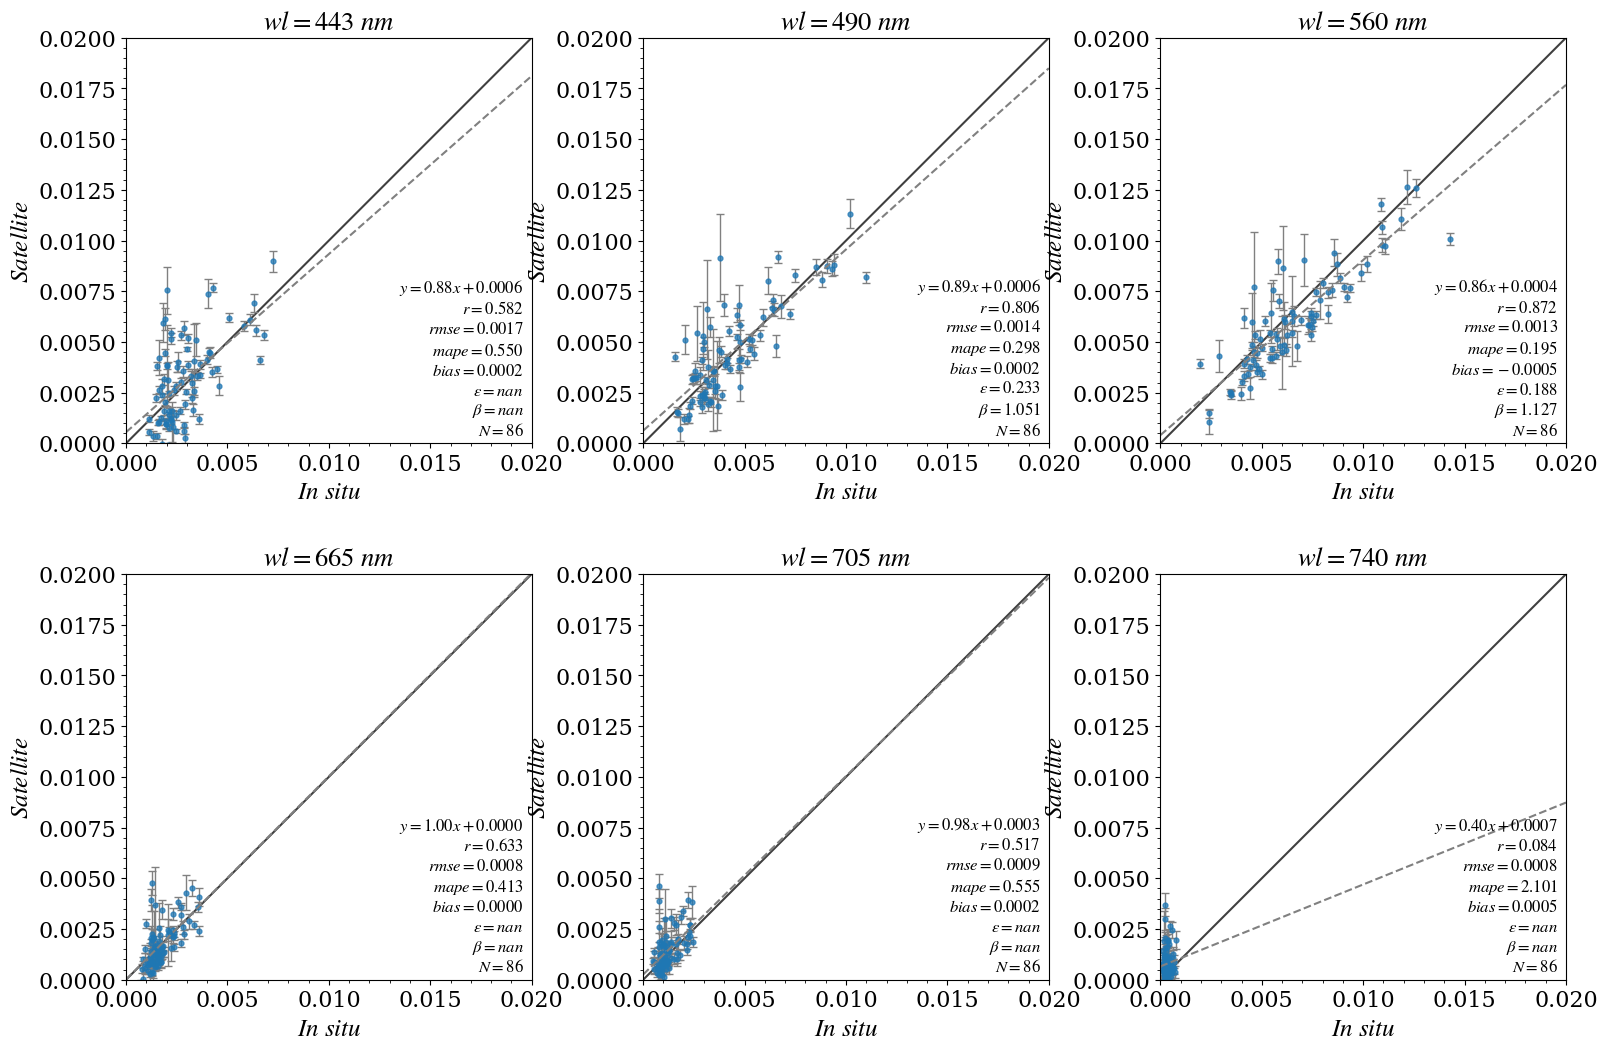

In [112]:
sat_var='Rrs_median'
insitu_var= 'isRrs_nadir_median'
xmin,xmax=0,0.02


rows=2
cols=3
u = grstbx.utils
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5+1, rows * 5+1.))  # ,sharey=True
fig.subplots_adjust(hspace=0.275, wspace=0.275,left=0.065, right=0.965,bottom=0.08, top=0.95)
axs=axs.ravel()
for ii, wl in enumerate(matchup_data.isel(wl=slice(0,6)).wl.values):
    ax=axs[ii]
    matchup_data_ = matchup_data.sel(wl=wl).dropna('date')
   
    x,y=matchup_data_[insitu_var].values.ravel(),matchup_data_[sat_var].values.ravel()
    
    all_values = [*x,*y]
    #xmin,xmax=np.min([0,np.min(all_values)])*1.1,np.max(all_values)*1.1

  
    ax.plot(x,y,ls='',marker='o',ms=3.5,alpha=0.75,zorder=2)
    #im2 = matchup_.groupby('station').plot.scatter(x=insitu_var,y=sat_var,ax=ax)
    ax.errorbar(x,y,
    #            xerr=matchup[insitu_var.replace('mean','std')].values.ravel(),
                yerr=matchup_data_['Rrs_std'].values.ravel(),
                color='gray',fmt='none',lw=1, capsize=3,zorder=1)# ecolor=resdf.spm_norm, zorder=9)

    add_stats(x,y,ax,label=True)

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([xmin,xmax])
    ax.minorticks_on()
    

    ax.set_title(r'$wl='+str(wl)+'\ nm$')
    ax.set_xlabel(r'$In\ situ\ $')
    ax.set_ylabel(r'$Satellite\ $')


for ax in axs.ravel():
    u.Plotting.set_layout(ax)

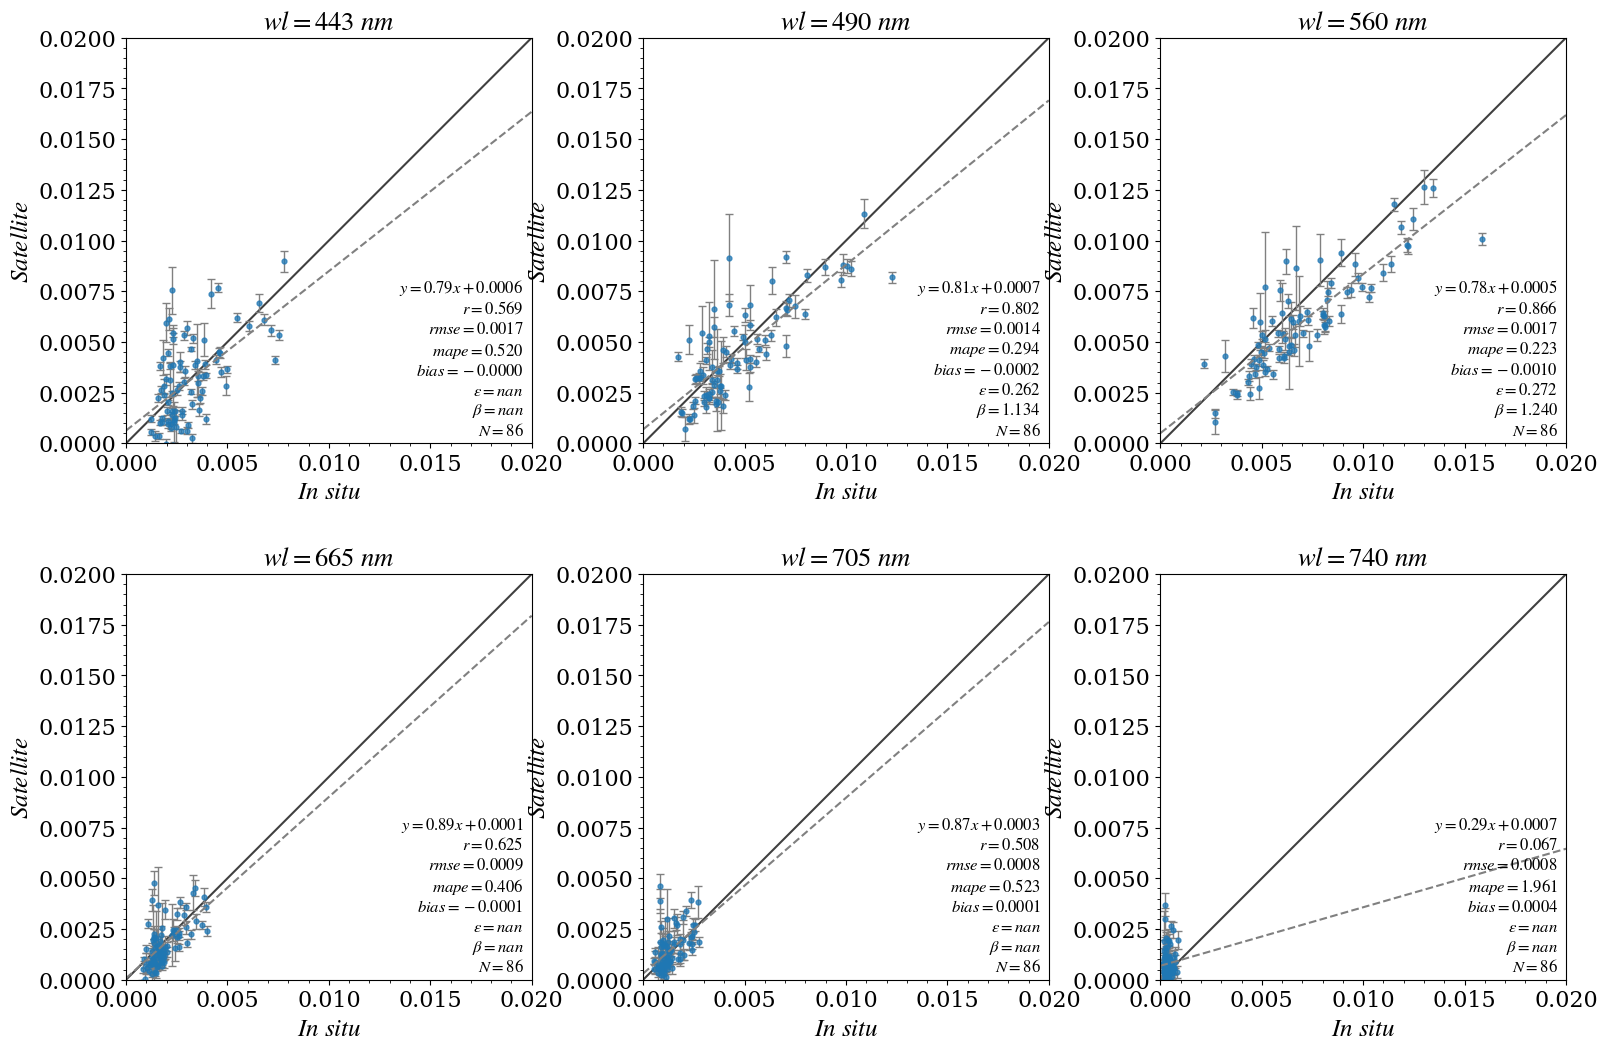

In [113]:
sat_var='Rrs_median'
insitu_var= 'isRrs_corr_median'
xmin,xmax=0,0.02


rows=2
cols=3
u = grstbx.utils
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5+1, rows * 5+1.))  # ,sharey=True
fig.subplots_adjust(hspace=0.275, wspace=0.275,left=0.065, right=0.965,bottom=0.08, top=0.95)
axs=axs.ravel()
for ii, wl in enumerate(matchup_data.isel(wl=slice(0,6)).wl.values):
    ax=axs[ii]
    matchup_data_ = matchup_data.sel(wl=wl).dropna('date')
   
    x,y=matchup_data_[insitu_var].values.ravel(),matchup_data_[sat_var].values.ravel()
    
    all_values = [*x,*y]
    #xmin,xmax=np.min([0,np.min(all_values)])*1.1,np.max(all_values)*1.1

  
    ax.plot(x,y,ls='',marker='o',ms=3.5,alpha=0.75,zorder=2)
    #im2 = matchup_.groupby('station').plot.scatter(x=insitu_var,y=sat_var,ax=ax)
    ax.errorbar(x,y,
    #            xerr=matchup[insitu_var.replace('mean','std')].values.ravel(),
                yerr=matchup_data_['Rrs_std'].values.ravel(),
                color='gray',fmt='none',lw=1, capsize=3,zorder=1)# ecolor=resdf.spm_norm, zorder=9)

    add_stats(x,y,ax,label=True)

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([xmin,xmax])
    ax.minorticks_on()
    

    ax.set_title(r'$wl='+str(wl)+'\ nm$')
    ax.set_xlabel(r'$In\ situ\ $')
    ax.set_ylabel(r'$Satellite\ $')


for ax in axs.ravel():
    u.Plotting.set_layout(ax)

Text(0.5, 1.0, 'After anisotropy correction')

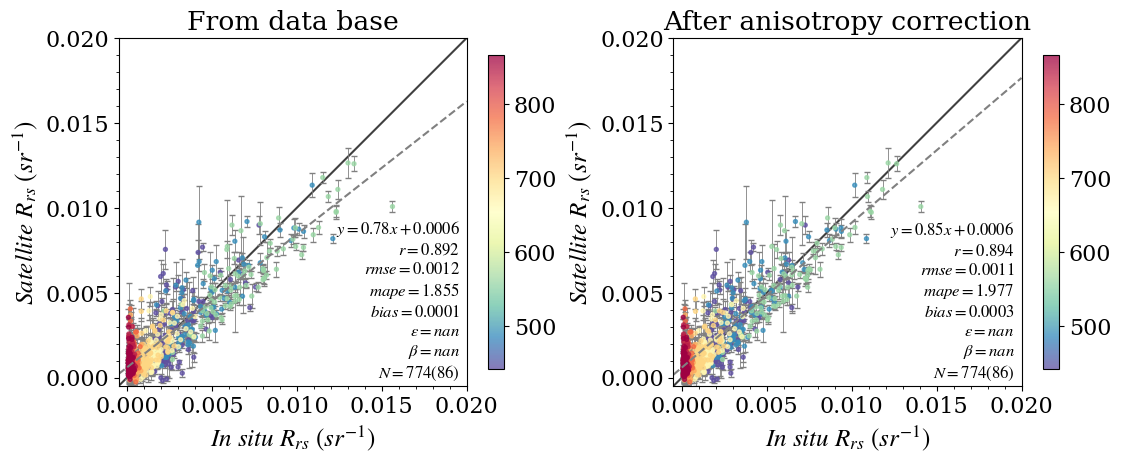

In [114]:
matchup_df_ = matchup_df.dropna()
cmap = plt.cm.Spectral_r

norm = mpl.colors.Normalize(vmin=440, vmax=800)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)



sat_var='Rrs_median'
insitu_vars= ['isRrs_corr_mean','isRrs_nadir_mean']
rows=1
cols=2
xmin,xmax=-0.0005,0.02
u = grstbx.utils
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5+1, rows * 5+1.))  # ,sharey=True
fig.subplots_adjust(hspace=0.275, wspace=0.275,left=0.065, right=0.965,bottom=0.08, top=0.95)
axs=axs.ravel()
for ii in range(2):
    ax=axs[ii]
    insitu_var=insitu_vars[ii]
    #matchup_data_ = matchup_data.sel(wl=wl).dropna('time')
   
    x,y,wl=matchup_df_[insitu_var].values,matchup_df_[sat_var].values,matchup_df_['wl'].values
    
    all_values = [*x,*y]
   

  
    g=ax.scatter(x,y,alpha=0.75,s=8,zorder=2,c=wl,cmap=cmap)
    #im2 = matchup_.groupby('station').plot.scatter(x=insitu_var,y=sat_var,ax=ax)
    ax.errorbar(x,y,
    #            xerr=matchup[insitu_var.replace('mean','std')].values.ravel(),
                yerr=matchup_df_['Rrs_std'].values,
                color='gray',fmt='none',lw=0.6, capsize=2,zorder=1)# ecolor=resdf.spm_norm, zorder=9)

    add_stats(x,y,ax,label=True,Nbands=9)

    ax.set_xlim([xmin,xmax])
    ax.set_ylim([xmin,xmax])
    ax.minorticks_on()
    cbar = fig.colorbar(g, shrink=0.6)

   # ax.set_title(r'$wl='+str(wl)+'\ nm$')
    ax.set_xlabel(r'$In\ situ\ R_{rs}\ (sr^{-1})$')
    ax.set_ylabel(r'$Satellite\ R_{rs}\ (sr^{-1})$')

ax.set_xlim([xmin,xmax])
ax.set_ylim([xmin,xmax])

for ax in axs.ravel():
    u.Plotting.set_layout(ax)

axs[0].set_title('From data base')
axs[1].set_title('After anisotropy correction')

